In [1]:
!pip install seaborn

In [4]:
from __future__ import absolute_import, division, print_function

import pathlib
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc3


In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [9]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  ...  Model Year  USA  Europe  Japan
393  27.0          4         140.0        86.0  ...          82  1.0     0.0    0.0
394  44.0          4          97.0        52.0  ...          82  0.0     1.0    0.0
395  32.0          4         135.0        84.0  ...          82  1.0     0.0    0.0
396  28.0          4         120.0        79.0  ...          82  1.0     0.0    0.0
397  31.0          4         119.0        82.0  ...          82  1.0     0.0    0.0

[5 rows x 10 columns]

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

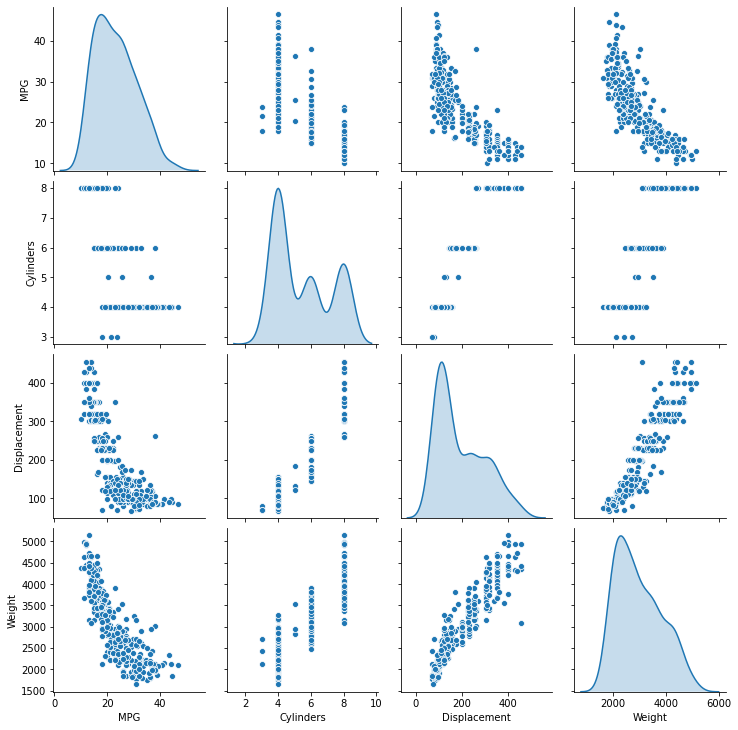

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [12]:
train_stat = train_dataset.describe()
train_stat.pop("MPG")
train_stat = train_stat.transpose()
train_stat

count         mean         std  ...     50%      75%     max
Cylinders     314.0     5.477707    1.699788  ...     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589  ...   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214  ...    94.5   128.00   225.0
Weight        314.0  2990.251592  843.898596  ...  2822.5  3608.00  5140.0
Acceleration  314.0    15.559236    2.789230  ...    15.5    17.20    24.8
Model Year    314.0    75.898089    3.675642  ...    76.0    79.00    82.0
USA           314.0     0.624204    0.485101  ...     1.0     1.00     1.0
Europe        314.0     0.178344    0.383413  ...     0.0     0.00     1.0
Japan         314.0     0.197452    0.398712  ...     0.0     0.00     1.0

[9 rows x 8 columns]

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stat['mean']) / train_stat['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
class PrintDot ( keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0 : print('')
    print('.',end = '')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


...........................................................................

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae       mse  val_loss   val_mae   val_mse  epoch
70  6.697979  1.841239  6.707150  8.672293  2.231091  8.663798     70
71  6.620475  1.821555  6.638860  8.664304  2.187089  8.654857     71
72  6.550740  1.820377  6.536878  9.187870  2.164733  9.198311     72
73  6.686530  1.833031  6.654801  8.715890  2.216096  8.703585     73
74  6.495048  1.841005  6.538707  9.151659  2.352458  9.131227     74

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(0.0, 20.0)

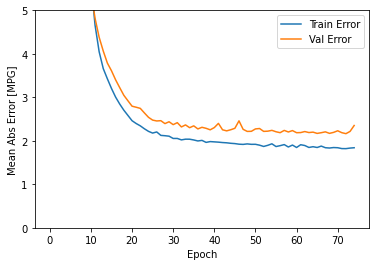

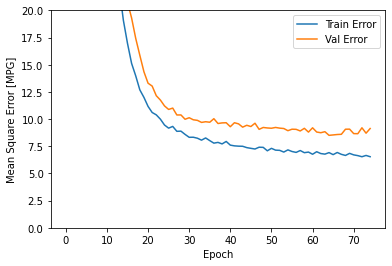

In [20]:
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MPG]')
plt.plot(hist['epoch'], hist['mae'], label = 'Train Error')
plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
plt.axes().set_ylim([0, 5])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MPG]')
plt.plot(hist['epoch'], hist['mse'], label = "Train Error")
plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
plt.legend()
plt.axes().set_ylim([0, 20])


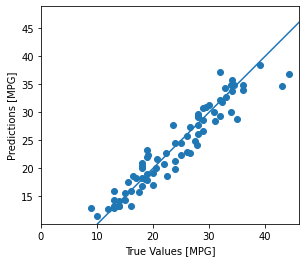

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
_ = plt.plot(lims, lims)

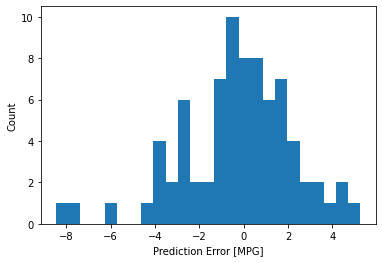

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")